In [1]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
#import squarify
%matplotlib inline
import random
#import missingno as msno
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template# The data to load

# Data Import

In [3]:
data = pd.read_csv("Data/MergedTrainData.csv")

In [4]:
transactions = pd.read_csv("Data/transactions.csv")
oil = pd.read_csv("Data/oil.csv")

# Unit Sales Vs Oil Prices

To begin, let's see if there's a correlation between unit sales and oil prices. The original problem statement suggested that due to Ecuador's economy being so strongly tied to oil, that perhaps a worldwide drop in oil prices would result in a drop in sales. If this is true, we should note a positive correllation between oil prices and unit sales. I will use a pivot table to group unit sales by date. We can then merge the resulting data frame with oil prices. 

In [5]:
# Sum up unit_sales by date
unit_sales_vs_oil_df = pd.pivot_table(data=data, index='date', values='unit_sales', aggfunc='sum', dropna=False)

In [6]:
unit_sales_vs_oil_df = pd.merge(unit_sales_vs_oil_df, oil, on='date', how='left')

In [7]:
# Replace NaN values using backward fill to cover first date 
unit_sales_vs_oil_df['dcoilwtico'].fillna(method='bfill', inplace=True)

We can get a preliminary visual of the behavior of unit sales as oil prices change by simply plotting the two against the same timeline. It appears unit sales increase over time, while oil prices experience a drastic drop around 2014. It's nice to see these two factors juxtaposed, but it is too difficult to draw any conclusions. 

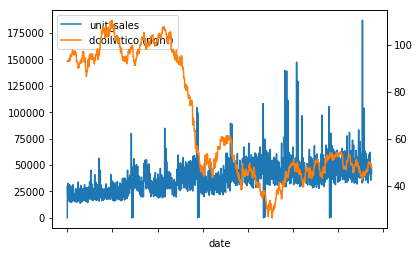

In [8]:
#unit_sales_vs_oil_df.plot(y=['unit_sales', 'dcoilwtico'], secondary_y=True)
ax = unit_sales_vs_oil_df.plot('date','unit_sales')
unit_sales_vs_oil_df.plot('date','dcoilwtico',secondary_y=True, ax=ax)

# Hypothesis 1

As our first statistical test, let us test the null hypothesis that there is no correllation between oil prices and unit sales. 

H0 - No statistically significant correllation exists between oil prices and unit sales

Ha - There is a statistically significant correlation between oil prices and unit sales

Alpha = 0.05

To start, let's create a scatter plot of our data consisting of unit sales compared to oil prices. 

In [9]:
unit_sales = unit_sales_vs_oil_df['unit_sales'].values
oil_prices = unit_sales_vs_oil_df['dcoilwtico'].values

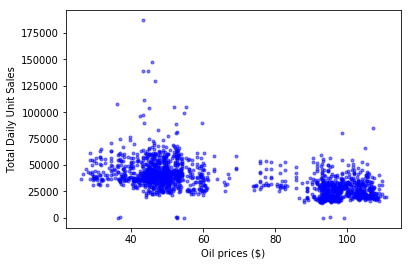

In [10]:
# Make a scatter plot of the data
_ = plt.plot(oil_prices, unit_sales, marker = '.', 
            linestyle='none', color='blue', alpha=0.5)
_ = plt.xlabel('Oil prices ($)')
_ = plt.ylabel('Total Daily Unit Sales')

In [11]:
# Calculate the correlation
pearson_r = np.corrcoef(unit_sales, oil_prices)[0, 1]

In [12]:
pearson_r

-0.5150459385592644

Based on the plot above and the Pearson correlation coefficient of -0.515, it appears there is a practically significant correlation between oil prices and unit sales. Let's use bootstrapping permutation techniques to see if this correllation is statistically significant. 

In [13]:
# Initialize permutation replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute unit sales 
    unit_sales_perm = np.random.permutation(unit_sales)
    
    # Compute Pearson correlation
    perm_replicates[i] = np.corrcoef(unit_sales_perm, oil_prices)[0,1]

# Compute p-value
p = np.sum(perm_replicates <= pearson_r) / len(perm_replicates)
print('p-value = ', p)

p-value =  0.0


It looks like the correllation coefficient we calculated is statistically significant with a p-value of 0.0. This is less that the alpha level of 0.05, and would still qualify if our level was only 0.01. Hence, it appears that there really is a negative correllation that is both statistically and practically significant. 

In [14]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    
    # Set up array of indices to sample from
    inds = np.arange(len(x))
    
    # Initialize replicates
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
        
    return bs_slope_reps, bs_intercept_reps

Now, let's go ahead and use bootstrapping to calculate a confidence interval for the linear regression slope and intercepts. We can then plot these to get a visual of the correllation. 

Slope =  -300.31037896946935 conf int = [-322.30577068 -277.6472981 ]
Intercept = 57235.93412941714 conf int = [55359.81747841 59039.29341514]


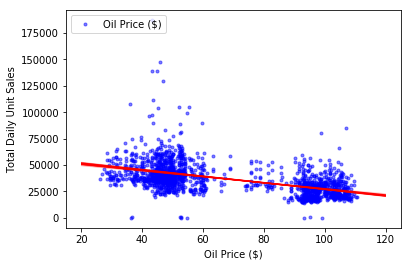

In [17]:
# Compute the linear regression
slope, intercept = np.polyfit(oil_prices, unit_sales, 1)

# Perform pairs bootstra for the linear regression
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(oil_prices, unit_sales, 1000)

# Compute confidence intervals of slope and intercept
slope_conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])
intercept_conf_int = np.percentile(bs_intercept_reps, [2.5, 97.5])

# Print the results
print('Slope = ', slope, 'conf int =', slope_conf_int)
print('Intercept =', intercept, 'conf int =', intercept_conf_int)

# Make a scatter plot of the data
_ = plt.plot(oil_prices, unit_sales, marker = '.', 
            linestyle='none', color='blue', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('Oil Price ($)')
_ = plt.ylabel('Total Daily Unit Sales')
_ = plt.legend(('Oil Price ($)', 'Total Daily Unit Sales'), loc='upper left')

# Generate x-values for bootstrap lines
x = np.array([20, 120])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

# Hypothesis 2 - Store 44

At this point, it seems pretty clear that there is a negative correlation between oil prices and unit sales. We see that oil prices experienced a drop over time. Over this same time, Corporacion Favorita may have opened new locations which would have resulted in higher total daily unit sales, even if individual store locations experienced a drop. To test this, I decided to perform the same analysis on only the store with the highest total unit sales. 

In [18]:
# Let's sort the store numbers by the sum of all their unit sales. We'll perform the same analysis on only the top store
_ = pd.pivot_table(data=data, index='store_nbr', values='unit_sales', aggfunc='sum', dropna=False)
_.sort_values(by=['unit_sales'], ascending=False).head(1)

,unit_sales
store_nbr,
44,3.902336e+06
3,3.274049e+06
45,3.053494e+06
47,2.952135e+06
46,2.472466e+06


In [19]:
# The store with the top sales is store 44, let's filter on that store and check the correlation with oil prices. 
store_44_unit_sales = data[data['store_nbr'] == 44]

In [20]:
# We aggregate the total unit sales by date
unit_sales_vs_oil_store44_df = pd.pivot_table(data=store_44_unit_sales, index='date', values='unit_sales', aggfunc='sum', dropna=False)

In [22]:
# Merge the unit sales of store 44 with oil price data
unit_sales_vs_oil_store44_df = pd.merge(unit_sales_vs_oil_store44_df, oil, on='date', how='left')

In [23]:
# Replace NaN values using backward fill to cover first date 
unit_sales_vs_oil_store44_df['dcoilwtico'].fillna(method='bfill', inplace=True)

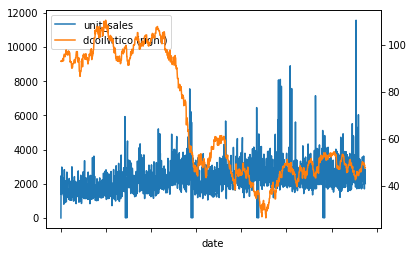

In [24]:
#unit_sales_vs_oil_df.plot(y=['unit_sales', 'dcoilwtico'], secondary_y=True)
ax = unit_sales_vs_oil_store44_df.plot('date','unit_sales')
unit_sales_vs_oil_store44_df.plot('date','dcoilwtico',secondary_y=True, ax=ax)

## Hypothesis 2 

H0 - There is no correlation between oil prices and unit sales for store number 44. 

Ha - There is a correlation between oil prices and store number 44.

Alpha - 0.05

In [25]:
unit_sales_44 = unit_sales_vs_oil_store44_df['unit_sales'].values
oil_prices_44 = unit_sales_vs_oil_store44_df['dcoilwtico'].values

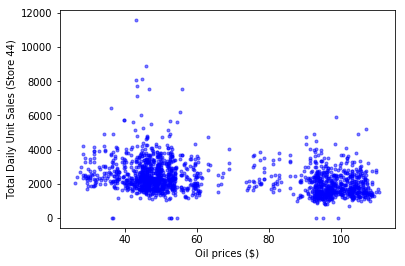

In [26]:
# Make a scatter plot of the data
_ = plt.plot(oil_prices_44, unit_sales_44, marker = '.', 
            linestyle='none', color='blue', alpha=0.5)
_ = plt.xlabel('Oil prices ($)')
_ = plt.ylabel('Total Daily Unit Sales (Store 44)')

In [27]:
# Calculate the correlation
pearson_r = np.corrcoef(unit_sales_44, oil_prices_44)[0, 1]

In [28]:
pearson_r

-0.3272495447916338

Immediately we see that the negative correlation, while still present, is nowhere near as practically significant as before (-.515). This suggests that on the individual store level, oil prices played a smaller role than at the aggregate level. Therefore, the increase of unit sales may have had more to do with new locations being opened, and with a general growth of operations, than with oil prices. 

Let's verify that the resulting Pearson correlation coefficient is statistically significant using bootstrapping techniques. 

In [29]:
# Initialize permutation replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute number of discharges 
    unit_sales_perm = np.random.permutation(unit_sales_44)
    
    # Compute Pearson correlation
    perm_replicates[i] = np.corrcoef(unit_sales_perm, oil_prices_44)[0,1]

# Compute p-value
p = np.sum(perm_replicates <= pearson_r) / len(perm_replicates)
print('p-value = ', p)

p-value =  0.0


It appears that out of 10000 permutations of our sales and oil price data, none had a correlation coefficient less than our original data set. This suggests a p-value of less than 0.01, and definitely less than 0.05. This result is definitely statistically significant. 

Slope =  -11.95015066977307 conf int = [-13.56819903 -10.39540478]
Intercept = 3122.5718354436067 conf int = [2994.96231618 3251.00332397]


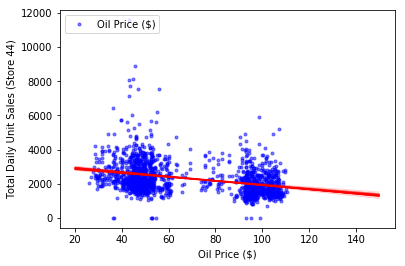

In [30]:
# Compute the linear regression
slope, intercept = np.polyfit(oil_prices_44, unit_sales_44, 1)

# Perform pairs bootstra for the linear regression
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(oil_prices_44, unit_sales_44, 1000)

# Compute confidence intervals of slope and intercept
slope_conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])
intercept_conf_int = np.percentile(bs_intercept_reps, [2.5, 97.5])

# Print the results
print('Slope = ', slope, 'conf int =', slope_conf_int)
print('Intercept =', intercept, 'conf int =', intercept_conf_int)

# Make a scatter plot of the data
_ = plt.plot(oil_prices_44, unit_sales_44, marker = '.', 
            linestyle='none', color='blue', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('Oil Price ($)')
_ = plt.ylabel('Total Daily Unit Sales (Store 44)')
_ = plt.legend(('Oil Price ($)', 'Total Daily Unit Sales (Store 44)'), loc='upper left')

# Generate x-values for bootstrap lines
x = np.array([20, 150])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

The plot above shows the confidence interval of the linear regression plot. It suggests that for every dollar increase in the price of oil, the number of unit sales decreases by anywhere from 10.5 to 13.5 units. However, the Pearson coefficient of -.3 suggests that this correlation is not that strong. 

## Hypothesis 1 and 2 Conclusion 

Based on the Hypothesis 1 and 2 above in which we tested to see if there was a correlation between oil prices and unit sales, we found that there is a negative correlation, meaning that as oil prices went down, unit sales went up. The original problem statement suggested that due to Ecuador's economic ties to oil, the opposite relationship may hold. Based on our findings, I think it is safe to say that the drop in oil prices did not result in the expected drop in sales. 

# Unit Sales vs Open Store Count

In the analysis above, we found that high oil prices (a proxy for a booming economy in Ecuador) did not correlate positively with increased sales. As a matter of fact, there was a slight negative correlation. I suspect new store locations may have opened up that may have contributed to the increase in unit sales over time. I'd like to see how strong the correlation is, if one exists. 

In [31]:
# To start, let's combine all unit sales by location and date
unit_sales_vs_stores_df = pd.pivot_table(data=data, index=('date', 'store_nbr'), values='unit_sales', aggfunc='sum', dropna=False)

# Filter on only those store and date combinations where the unit sales was greater than 0
unit_sales_vs_stores_df = unit_sales_vs_stores_df[unit_sales_vs_stores_df['unit_sales'] > 0]
unit_sales_vs_stores_df.head()

unit_sales
date       store_nbr            
2013-01-01 25            151.060
2013-01-02 1             450.748
           2             640.795
           3            1788.128
           4             579.728

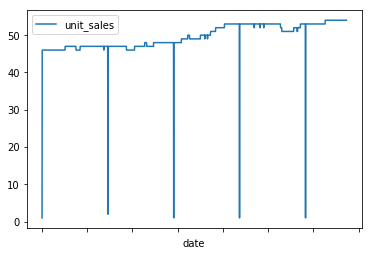

In [32]:
# Create a table that contains how many stores had sales on a given date
stores_over_time_df = pd.pivot_table(data=unit_sales_vs_stores_df, index='date', values='unit_sales', aggfunc='count', dropna=False)

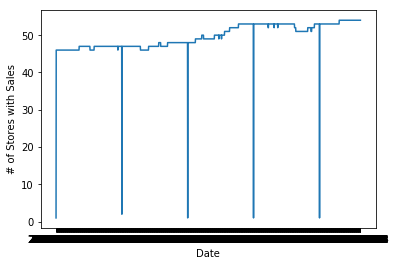

In [33]:
#stores_over_time_df.plot()
_ = plt.plot(stores_over_time_df)
_ = plt.xlabel('Date')
_ = plt.ylabel('# of Stores with Sales')
plt.show()

Based on the plot, it appears that there were in fact some new store locations opened. Let's see how the number of store locations correlates with unit sales. 

In [35]:
stores_vs_unit_sales = pd.merge(stores_over_time_df, unit_sales_vs_oil_df, on='date', how='left')

In [36]:
# There are a handful of days where only one or two stores have sales. These appear to be outliers and they throw off the plot.
# Filtering to days with at least 40 stores with sales
stores_vs_unit_sales = stores_vs_unit_sales[stores_vs_unit_sales['unit_sales_x'] > 40]

,date,unit_sales_x,unit_sales_y,dcoilwtico
1,2013-01-02,46,30328.308,93.14
2,2013-01-03,46,21833.869,92.97
3,2013-01-04,46,21593.770,93.12
4,2013-01-05,46,28601.051,93.20
5,2013-01-06,46,32789.518,93.20


In [37]:
unit_sales = stores_vs_unit_sales['unit_sales_y'].values
store_cnt = stores_vs_unit_sales['unit_sales_x'].values

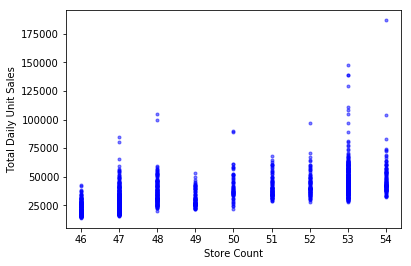

In [38]:
# Make a scatter plot of the data
_ = plt.plot(store_cnt, unit_sales, marker = '.', 
            linestyle='none', color='blue', alpha=0.5)
_ = plt.xlabel('Store Count')
_ = plt.ylabel('Total Daily Unit Sales')

In [40]:
# Calculate the correlation
pearson_r = np.corrcoef(unit_sales, store_cnt)[0, 1]

In [41]:
pearson_r

0.5896455104882937

Here we see a much stronger positive correlation, meaning that, as expected, as the number of stores goes up, the unit sales also go up. For this reason, I believe the increase in unit sales had more to do with new stores opening up as opposed to changes in oil price. 

In [42]:
# Initialize permutation replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute number of discharges 
    unit_sales_perm = np.random.permutation(unit_sales)
    
    # Compute Pearson correlation
    perm_replicates[i] = np.corrcoef(unit_sales_perm, store_cnt)[0,1]

# Compute p-value
p = np.sum(perm_replicates > pearson_r) / len(perm_replicates)
print('p-value = ', p)

p-value =  0.0


Using a bootstrap permutation to replicate the data, we see that in 10000 trials, none of the trials had a higher correlation than the original data. Because the p-value is below the alpha, we can reject the null hypothesis and conclude that there is a correlation between the number of unit sales and store locations. 

Slope =  3039.265194812615 conf int = [2845.56345689 3247.8420302 ]
Intercept = -114265.2744766263 conf int = [-124450.45396299 -104650.42998147]


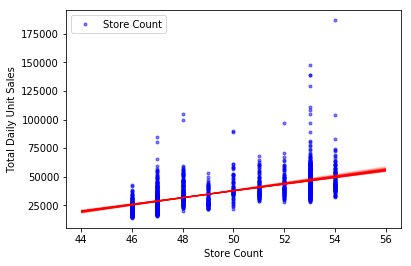

In [43]:
# Compute the linear regression
slope, intercept = np.polyfit(store_cnt, unit_sales, 1)

# Perform pairs bootstra for the linear regression
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(store_cnt, unit_sales, 1000)

# Compute confidence intervals of slope and intercept
slope_conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])
intercept_conf_int = np.percentile(bs_intercept_reps, [2.5, 97.5])

# Print the results
print('Slope = ', slope, 'conf int =', slope_conf_int)
print('Intercept =', intercept, 'conf int =', intercept_conf_int)

# Make a scatter plot of the data
_ = plt.plot(store_cnt, unit_sales, marker = '.', 
            linestyle='none', color='blue', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('Store Count')
_ = plt.ylabel('Total Daily Unit Sales')
_ = plt.legend(('Store Count', 'Total Daily Unit Sales'), loc='upper left')

# Generate x-values for bootstrap lines
x = np.array([44, 56])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

Here we see the linear regression line with a 95% confidence interval for the slope and intercept. We can interpret this as meaning that each addition store added about 3000 units of sales to each day. 